In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/5g-nidd-dataset/Combined.csv
/kaggle/input/csv-preprocessed/csv_preprocessed.csv


In [2]:
# import shutil

# input_path = '/kaggle/input/csv-preprocessed'
# output_path = '/kaggle/working/csv-preprocessed'
# # Copy dataset into working directory
# shutil.copytree(input_path, output_path)

In [3]:
cd /kaggle/working/csv-preprocessed

/kaggle/working/csv-preprocessed


In [42]:
!pip install torch
!pip install torchviz
!pip install torchsummary
!pip install torchmetrics --upgrade

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import scipy
import sklearn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torchmetrics
import torchsummary
import torchviz

%matplotlib inline

In [6]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
device

Torch 2.1.2 CUDA 12.1
Device: cuda:0


device(type='cuda')

In [7]:
# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()

# how many samples per batch to load
batch_size = 64

# percentage of data set to use as validation
valid_size = 0.15

In [8]:
df = pd.read_csv('csv_preprocessed.csv', low_memory=False)
print(df.shape)
df.head()

(1215675, 63)


,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP,Attack Type
0,-0.807085,-0.069046,-0.094739,-0.419379,-0.00732,1.050111,-0.973059,-0.167011,-0.146696,-0.115856,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.807085,-0.069046,-0.094739,-0.419379,-0.00732,1.050111,-0.973059,-0.167011,-0.146696,-0.115856,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,2.147963,-0.069046,-0.094739,0.635573,-0.00732,2.452913,-0.973059,8.414004,10.443194,1.327973,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2.147973,-0.069046,-0.094739,0.635573,-0.00732,2.452913,-0.973059,7.205410,8.651059,1.568612,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2.148810,-0.069046,-0.094739,0.635573,-0.00732,2.452913,-0.973059,8.776582,10.877651,1.408186,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
num_classes = df['Attack Type'].nunique()
print(num_classes)

9


In [10]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Attack Type'], df['Attack Type'],
                                                    stratify=df['Attack Type'], 
                                                    shuffle=True,
                                                    test_size=0.15)

X_train = pd.DataFrame(X_train, columns=df.drop(columns=['Attack Type']).columns.to_list())
X_test = pd.DataFrame(X_test, columns=df.drop(columns=['Attack Type']).columns.to_list())
y_train = pd.DataFrame(y_train, columns=['Attack Type'])
y_test = pd.DataFrame(y_test, columns=['Attack Type'])

print("Training dataset size:", X_train.shape)
print("Testing dataset size:", X_test.shape)
print("Training target size:", y_train.shape)
print("Testing target size:", y_test.shape)

Training dataset size: (1033323, 62)
Testing dataset size: (182352, 62)
Training target size: (1033323, 1)
Testing target size: (182352, 1)


In [11]:
class CustomTabularDataset(Dataset):
    def __init__(self, data):
        # Load and preprocess your tabular data here
        self.features = torch.tensor(data['features'].values, dtype=torch.float32)
        self.labels = torch.tensor(data['labels'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [12]:
train_data = {'features': X_train,  # Your feature data (Pandas DataFrame or similar)
        'labels': y_train}     # Your label data

dataset = CustomTabularDataset(train_data)

In [13]:
train_idx, valid_idx= train_test_split(np.arange(len(dataset.labels)), test_size=0.15, random_state=42, shuffle=True, stratify=dataset.labels)

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx.tolist())
valid_sampler = SubsetRandomSampler(valid_idx.tolist())

In [14]:
print('Training set size:', len(train_idx))
print('Validation set size:', len(valid_idx))
print('Testing set size:', len(X_test))

Training set size: 878324
Validation set size: 154999
Testing set size: 182352


In [15]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)

In [16]:
# Number of features
num_features = X_train.shape[1]

In [17]:
# Creating a PyTorch class
# input_features ==> 12 ==> 32
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Building an linear encoder with Linear
        # layer followed by Tanh activation function
        # input_features ===> 12
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_features, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 12),
            torch.nn.Tanh()
        )
        
        # Dense neural network layers
        self.dense_nn = torch.nn.Sequential(
            torch.nn.Linear(12, 32),  # Input size is 12 from the encoder
            torch.nn.BatchNorm1d(32),            
            torch.nn.ReLU(), 
            torch.nn.Dropout(0.2),          
            torch.nn.Linear(32, num_classes),  # Output size is the number of classes
            torch.nn.Softmax(dim=1)
        )        

    def forward(self, x):
        encoded = self.encoder(x)
        output = self.dense_nn(encoded)
        return output

In [18]:
# Model Initialization
model = Autoencoder()

# Validation using CrossEntropyLoss function
loss_function = torch.nn.CrossEntropyLoss()

# Using an Adam Optimizer with lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),
                            lr = 0.001,
                            weight_decay = 1e-8)


In [35]:
from torchviz import make_dot

batch = next(iter(train_loader))
yhat = model(batch[0]) # Give dummy batch to forward().
make_dot(yhat, params=dict(list(model.named_parameters()))).render("dnn_torchviz", format="png")

'dnn_torchviz.png'

In [46]:
# number of epochs to train the model
n_epochs = 16

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
train_loss_min = np.Inf # set initial "min" to infinity

# Lists to store training and validation accuracy during training
training_loss = np.array([])
validation_loss = np.array([])

training_accuracy = np.array([])
validation_accuracy = np.array([])

# Moving model tensor to GPU if available
model = model.to(device)

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0
    total_valid_correct = 0
    total_valid_samples = 0

    ###################
    # train the model #
    ###################

    # model by default is set to train
    model.train()

    for data, target in tqdm(train_loader):        

        # Moving input tensors to GPU if available
        data, target = data.to(device), target.to(device)

        # Forward prop:

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())    
        
        # Moving output tensor to GPU if available
        output = output.to(device)

        # calculate the batch loss
        loss = loss_function(output, target.reshape(-1).long())
        
        # Backward prop:

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()

        # Metrics:

        # update training loss
        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(output, 1)
        total_train_correct += (predicted == target.view(*predicted.shape)).sum().item()
        total_train_samples += target.size(0)


    ######################
    # validate the model #
    ######################

    model.eval() # prep model for evaluation

    for data, target in tqdm(valid_loader):
        
        # Moving input tensors to GPU if available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        output = output.to(device)
        
        # calculate the loss
        loss = loss_function(output, target.reshape(-1).long())        
        
        # update running validation loss
        valid_loss += loss.item()
        
        # Calculate validation accuracy
        _, predicted = torch.max(output, 1)
        total_valid_correct += (predicted == target.view(*predicted.shape)).sum().item()
        total_valid_samples += target.size(0)


    # print training/validation statistics
    
    train_acc = 100 * total_train_correct / total_train_samples
    valid_acc = 100 * total_valid_correct / total_valid_samples
    
    training_accuracy = np.append(training_accuracy, train_acc)
    validation_accuracy = np.append(validation_accuracy, valid_acc)
    
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    training_loss = np.append(training_loss, train_loss)
    validation_loss = np.append(validation_loss, valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch,
        train_loss,
        valid_loss
    ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch,
        train_acc,
        valid_acc
    ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min and train_loss <= train_loss_min:
        print('Training loss decreased ({:.6f} --> {:.6f}).'.format(
            train_loss_min,
            train_loss))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model_pytorch_autoencoders.pt')
        valid_loss_min = valid_loss
        train_loss_min = train_loss

100%|██████████| 2422/2422 [00:08<00:00, 272.83it/s]


Epoch: 1 	Training Loss: 1.388209 	Validation Loss: 1.376284
Epoch: 1 	Training Accuracy: 98.670422 	Validation Accuracy: 99.563868
Training loss decreased (inf --> 1.388209).
Validation loss decreased (inf --> 1.376284).  Saving model ...


100%|██████████| 2422/2422 [00:08<00:00, 277.76it/s]


Epoch: 2 	Training Loss: 1.376215 	Validation Loss: 1.376078
Epoch: 2 	Training Accuracy: 99.583867 	Validation Accuracy: 99.585159
Training loss decreased (1.388209 --> 1.376215).
Validation loss decreased (1.376284 --> 1.376078).  Saving model ...


100%|██████████| 2422/2422 [00:08<00:00, 277.32it/s]


Epoch: 3 	Training Loss: 1.375820 	Validation Loss: 1.375284
Epoch: 3 	Training Accuracy: 99.616770 	Validation Accuracy: 99.665159
Training loss decreased (1.376215 --> 1.375820).
Validation loss decreased (1.376078 --> 1.375284).  Saving model ...


100%|██████████| 2422/2422 [00:08<00:00, 271.50it/s]


Epoch: 4 	Training Loss: 1.375754 	Validation Loss: 1.375279
Epoch: 4 	Training Accuracy: 99.622007 	Validation Accuracy: 99.667095
Training loss decreased (1.375820 --> 1.375754).
Validation loss decreased (1.375284 --> 1.375279).  Saving model ...


100%|██████████| 2422/2422 [00:08<00:00, 272.33it/s]


Epoch: 5 	Training Loss: 1.375515 	Validation Loss: 1.379643
Epoch: 5 	Training Accuracy: 99.644778 	Validation Accuracy: 99.230318


100%|██████████| 2422/2422 [00:11<00:00, 219.82it/s]


Epoch: 6 	Training Loss: 1.375508 	Validation Loss: 1.377396
Epoch: 6 	Training Accuracy: 99.644550 	Validation Accuracy: 99.456771


100%|██████████| 2422/2422 [00:09<00:00, 265.29it/s]


Epoch: 7 	Training Loss: 1.375432 	Validation Loss: 1.375761
Epoch: 7 	Training Accuracy: 99.651951 	Validation Accuracy: 99.617417


100%|██████████| 2422/2422 [00:09<00:00, 251.00it/s]


Epoch: 8 	Training Loss: 1.375372 	Validation Loss: 1.378204
Epoch: 8 	Training Accuracy: 99.657643 	Validation Accuracy: 99.375480


100%|██████████| 2422/2422 [00:09<00:00, 255.65it/s]


Epoch: 9 	Training Loss: 1.375319 	Validation Loss: 1.375162
Epoch: 9 	Training Accuracy: 99.663222 	Validation Accuracy: 99.678062
Training loss decreased (1.375754 --> 1.375319).
Validation loss decreased (1.375279 --> 1.375162).  Saving model ...


100%|██████████| 2422/2422 [00:09<00:00, 254.75it/s]


Epoch: 10 	Training Loss: 1.375139 	Validation Loss: 1.375143
Epoch: 10 	Training Accuracy: 99.682122 	Validation Accuracy: 99.679998
Training loss decreased (1.375319 --> 1.375139).
Validation loss decreased (1.375162 --> 1.375143).  Saving model ...


100%|██████████| 2422/2422 [00:09<00:00, 253.11it/s]


Epoch: 11 	Training Loss: 1.375133 	Validation Loss: 1.375552
Epoch: 11 	Training Accuracy: 99.682236 	Validation Accuracy: 99.639998


100%|██████████| 2422/2422 [00:09<00:00, 253.45it/s]


Epoch: 12 	Training Loss: 1.375196 	Validation Loss: 1.375953
Epoch: 12 	Training Accuracy: 99.675974 	Validation Accuracy: 99.600643


100%|██████████| 2422/2422 [00:09<00:00, 247.92it/s]


Epoch: 13 	Training Loss: 1.375078 	Validation Loss: 1.375236
Epoch: 13 	Training Accuracy: 99.687815 	Validation Accuracy: 99.671611


100%|██████████| 2422/2422 [00:13<00:00, 176.12it/s]


Epoch: 14 	Training Loss: 1.375009 	Validation Loss: 1.374773
Epoch: 14 	Training Accuracy: 99.694190 	Validation Accuracy: 99.716127
Training loss decreased (1.375139 --> 1.375009).
Validation loss decreased (1.375143 --> 1.374773).  Saving model ...


100%|██████████| 2422/2422 [00:09<00:00, 247.09it/s]


Epoch: 15 	Training Loss: 1.374992 	Validation Loss: 1.376478
Epoch: 15 	Training Accuracy: 99.695443 	Validation Accuracy: 99.548384


100%|██████████| 2422/2422 [00:09<00:00, 251.14it/s]

Epoch: 16 	Training Loss: 1.374967 	Validation Loss: 1.374897
Epoch: 16 	Training Accuracy: 99.698972 	Validation Accuracy: 99.705805


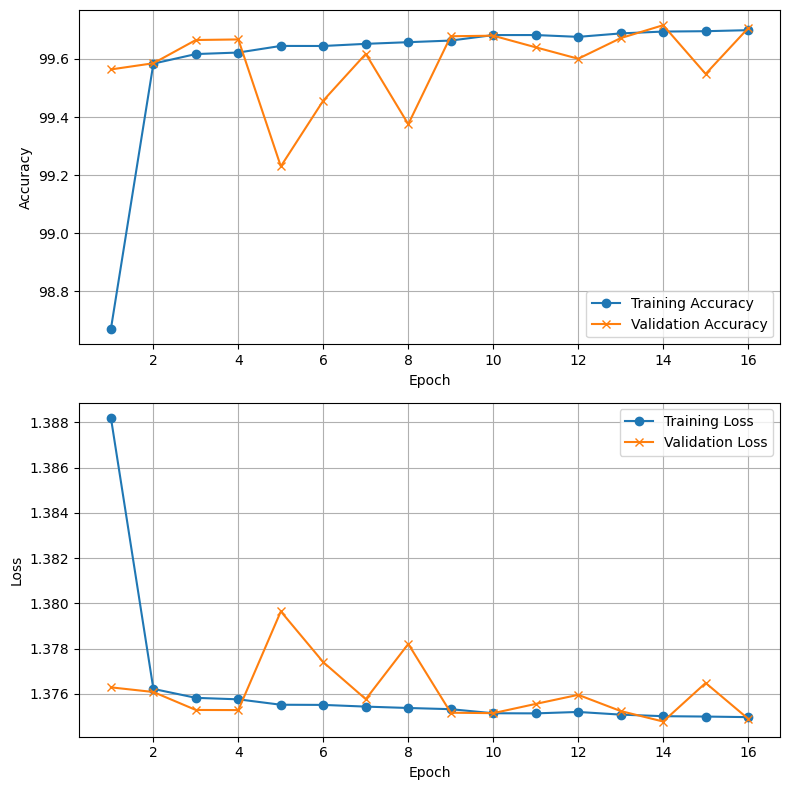

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
epochs = np.arange(1, n_epochs+1)

# First row for accuracy
ax[0].plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
ax[0].plot(epochs, validation_accuracy, label='Validation Accuracy', marker='x')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy', color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].legend(loc='lower right')
ax[0].grid(True)


# Second row for loss
ax[1].plot(epochs, training_loss, label='Training Loss', marker='o')
ax[1].plot(epochs, validation_loss, label='Validation Loss', marker='x')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss', color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].legend(loc='upper right')
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [48]:
from torchsummary import summary

model = model.to(device)

# Print model summary
summary(model, input_size=(batch[0].shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           2,016
              Tanh-2                   [-1, 32]               0
            Linear-3                   [-1, 16]             528
              Tanh-4                   [-1, 16]               0
            Linear-5                   [-1, 12]             204
              Tanh-6                   [-1, 12]               0
            Linear-7                   [-1, 32]             416
       BatchNorm1d-8                   [-1, 32]              64
              ReLU-9                   [-1, 32]               0
          Dropout-10                   [-1, 32]               0
           Linear-11                    [-1, 9]             297
          Softmax-12                    [-1, 9]               0
Total params: 3,525
Trainable params: 3,525
Non-trainable params: 0
-----------------------------------

Testing phase:

In [49]:
print("Testing dataset size:", X_test.shape)
print("Testing target size:", y_test.shape)

X_test.head()

Testing dataset size: (182352, 62)
Testing target size: (182352, 1)


,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Start,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP
19356,-0.807085,-0.069046,-9.473906e-02,-0.329976,-3.813893e-01,-0.352692,1.252708e+00,-0.167011,-0.146696,-0.115856,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
464706,-0.807085,-0.069046,-9.473906e-02,-0.329976,-7.320131e-03,-0.352692,-9.730588e-01,-0.167011,-0.146696,-0.115856,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
565346,2.119536,-0.069046,-9.473906e-02,-0.329976,-3.813893e-01,-0.352692,1.252708e+00,0.598431,0.233454,0.846697,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
309883,0.716608,-0.069046,-9.473906e-02,-0.329976,-7.320131e-03,-0.352692,-9.730588e-01,-0.126725,-0.092389,-0.115856,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
804375,0.800002,-0.069046,-1.773502e-16,-0.329976,1.190749e-13,-0.352692,-1.939318e-13,-0.126725,-0.092389,-0.115856,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [50]:
y_test.head()

,Attack Type
19356,6
464706,0
565346,1
309883,0
804375,7


In [51]:
test_data = {'features': X_test,  # Your feature data (Pandas DataFrame or similar)
        'labels': y_test}     # Your label data

test_dataset = CustomTabularDataset(test_data)

In [52]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)

In [53]:
model.load_state_dict(torch.load('model_pytorch_autoencoders.pt'))

<All keys matched successfully>

In [54]:
le_name_mapping = {'Benign': 0, 'HTTPFlood': 1, 'ICMPFlood': 2, 'SYNFlood': 3, 'SYNScan': 4, 'SlowrateDoS': 5, 'TCPConnectScan': 6, 'UDPFlood': 7, 'UDPScan': 8}
le_name_mapping

{'Benign': 0,
 'HTTPFlood': 1,
 'ICMPFlood': 2,
 'SYNFlood': 3,
 'SYNScan': 4,
 'SlowrateDoS': 5,
 'TCPConnectScan': 6,
 'UDPFlood': 7,
 'UDPScan': 8}

In [55]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0

class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# Initialize empty tensors for predictions and targets
all_preds_tensors = torch.tensor([])
all_targets_tensors = torch.tensor([])

# Moving model tensor to GPU if available
model = model.to(device)

model.eval() # prep model for evaluation

for data, target in tqdm(test_loader):
    
    # Moving input tensors to GPU if available
    data, target = data.to(device), target.to(device)    
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    output = output.to(device)    
    
    # calculate the loss
    loss = loss_function(output, target.reshape(-1).long())
    
    # update test loss
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # Concatenate predictions and targets tensors
    all_preds_tensors = torch.cat((all_preds_tensors, pred.cpu()), dim=0)
    all_targets_tensors = torch.cat((all_targets_tensors, target.squeeze().cpu()), dim=0)
    
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # calculate test accuracy for each object class
    for i in range(data.shape[0]):
        label = int(target.data[i].item())
        class_correct[label] += int(correct[i].item())
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

label_map = {}
for k, v in le_name_mapping.items():
    label_map[v] = k

for i in range(num_classes):
    if class_total[i] > 0:
        print(f'Test Accuracy of {str(i)}-{label_map[i]:<25}: {100 * class_correct[i] / class_total[i]:.6f}% ({int(np.sum(class_correct[i])):<2}/{int(np.sum(class_total[i])):<2})')
    else:
        print(f'Test Accuracy of {label_map[i]:<25}: N/A (no training examples)')

print(f'\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total):.6f}% ({int(np.sum(class_correct))} / {int(np.sum(class_total))})')

100%|██████████| 2850/2850 [00:18<00:00, 155.17it/s]

Test Loss: 1.374408

Test Accuracy of 0-Benign                   : 99.991624% (71623/71629)
Test Accuracy of 1-HTTPFlood                : 99.512357% (21019/21122)
Test Accuracy of 2-ICMPFlood                : 99.421965% (172/173)
Test Accuracy of 3-SYNFlood                 : 88.614540% (1292/1458)
Test Accuracy of 4-SYNScan                  : 99.966733% (3005/3006)
Test Accuracy of 5-SlowrateDoS              : 98.541344% (10809/10969)
Test Accuracy of 6-TCPConnectScan           : 99.933511% (3006/3008)
Test Accuracy of 7-UDPFlood                 : 100.000000% (68601/68601)
Test Accuracy of 8-UDPScan                  : 99.664711% (2378/2386)

Test Accuracy (Overall): 99.754870% (181905 / 182352)


Accuracy: 0.9975486993789673 

Precision: 0.9975922107696533 

Recall: 0.9975487589836121 

F1 Score: 0.9975332021713257 

Confusion Matrix:
tensor([[71623,     2,     0,     0,     0,     0,     4,     0,     0],
        [    0, 21019,     0,     5,     0,    98,     0,     0,     0],
        [    0,     0,   172,     0,     0,     0,     1,     0,     0],
        [    0,     0,     0,  1292,     0,     1,   165,     0,     0],
        [    0,     0,     0,     1,  3005,     0,     0,     0,     0],
        [    0,   160,     0,     0,     0, 10809,     0,     0,     0],
        [    0,     0,     0,     1,     1,     0,  3006,     0,     0],
        [    0,     0,     0,     0,     0,     0,     0, 68601,     0],
        [    0,     0,     0,     1,     7,     0,     0,     0,  2378]])


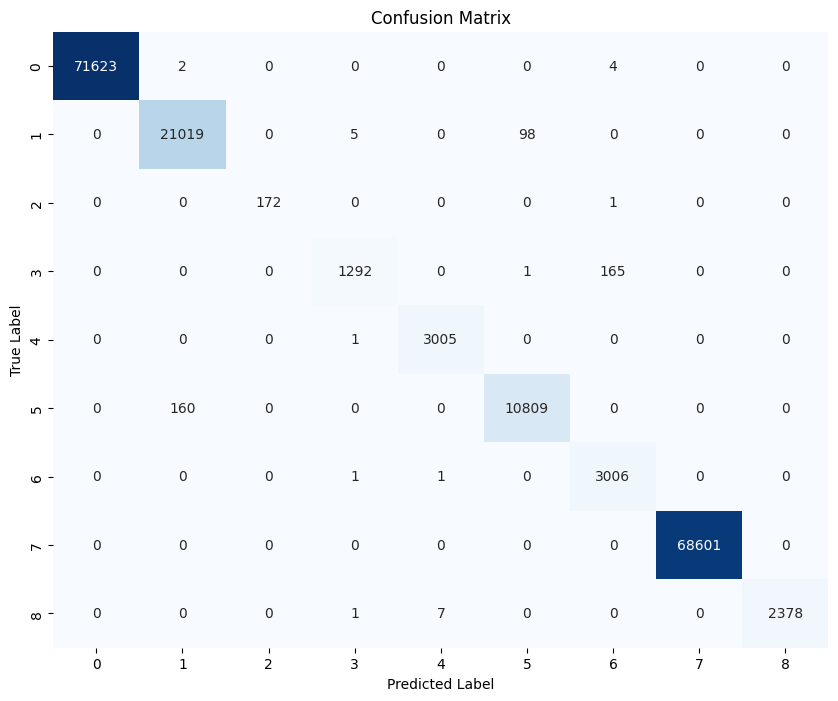

In [56]:
import torch
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
import matplotlib.pyplot as plt

# Initialize evaluation metrics
accuracy = Accuracy(task="multiclass", num_classes=num_classes)
precision = Precision(task="multiclass", num_classes=num_classes, average='weighted')
recall = Recall(task="multiclass", num_classes=num_classes, average='weighted')
f1 = F1Score(task="multiclass", num_classes=num_classes, average='weighted')
conf_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)

# Calculate evaluation metrics
accuracy_value = accuracy(all_preds_tensors, all_targets_tensors)
precision_value = precision(all_preds_tensors, all_targets_tensors)
recall_value = recall(all_preds_tensors, all_targets_tensors)
f1_value = f1(all_preds_tensors, all_targets_tensors)
conf_matrix_value = conf_matrix(all_preds_tensors, all_targets_tensors)

# Print the metrics
print(f"Accuracy: {accuracy_value} \n")
print(f"Precision: {precision_value} \n")
print(f"Recall: {recall_value} \n")
print(f"F1 Score: {f1_value} \n")
print(f"Confusion Matrix:\n{conf_matrix_value}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix.compute().numpy(), cmap='Blues', annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

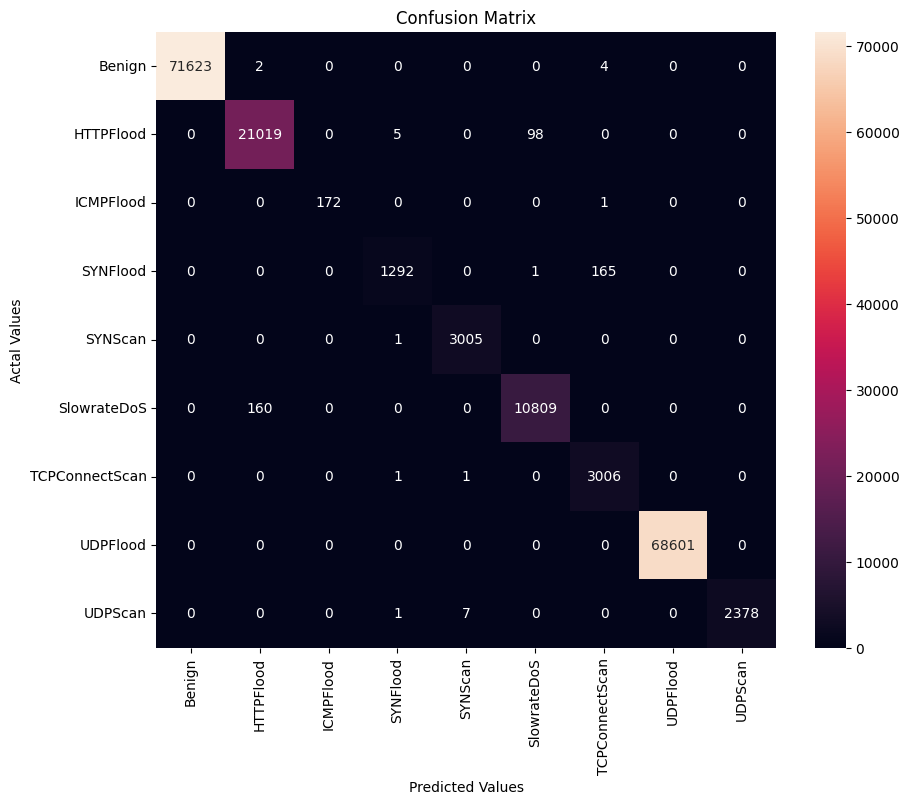

In [57]:
from sklearn.metrics import confusion_matrix

# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(all_targets_tensors.numpy(), all_preds_tensors.numpy())

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = le_name_mapping.keys(), 
                     columns = le_name_mapping.keys())

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [58]:
print(le_name_mapping)
cm_df

{'Benign': 0, 'HTTPFlood': 1, 'ICMPFlood': 2, 'SYNFlood': 3, 'SYNScan': 4, 'SlowrateDoS': 5, 'TCPConnectScan': 6, 'UDPFlood': 7, 'UDPScan': 8}


,Benign,HTTPFlood,ICMPFlood,SYNFlood,SYNScan,SlowrateDoS,TCPConnectScan,UDPFlood,UDPScan
Benign,71623,2,0,0,0,0,4,0,0
HTTPFlood,0,21019,0,5,0,98,0,0,0
ICMPFlood,0,0,172,0,0,0,1,0,0
SYNFlood,0,0,0,1292,0,1,165,0,0
SYNScan,0,0,0,1,3005,0,0,0,0
SlowrateDoS,0,160,0,0,0,10809,0,0,0
TCPConnectScan,0,0,0,1,1,0,3006,0,0
UDPFlood,0,0,0,0,0,0,0,68601,0
UDPScan,0,0,0,1,7,0,0,0,2378
